In [11]:
# Imports.
import nltk
import gensim
import numpy as np
import pandas as pd
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.corpus import stopwords
import csv
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import collections
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib.cm as cm

In [2]:
# GLobal variables.
WORDLIST_EN = [w for w in nltk.corpus.words.words('en') if w.islower()]
STOP_WORDS = set(stopwords.words('english'))

In [3]:
# Load Word2Vec news model.
vector_path = 'GoogleNewsVectors300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(vector_path, binary=True)

In [4]:
# Load raw dataset.
df_raw = pd.read_csv("../../data/pnlp_data_en.csv", delimiter=';')
df_raw.head(5)

,Report Grouping,Question Text,Comments
0,Large Department,Please tell us what is working well.,"we do what our customers need, we communicate ..."
1,Large Department,Please tell us what is working well.,Customs business development continues to grow...
2,Large Department,Please tell us what is working well.,"I think the team work hard, are committed to c..."
3,Large Department,Please tell us what is working well.,Overall working towards a customer centric env...
4,Large Department,Please tell us what is working well.,Customer centricity is a growing culture in th...


In [5]:
# Train sentence tokenizer.
corpus = ''
for index, row in df_raw.iterrows():
    corpus += row['Comments'].lower().replace('•', '') + ' '
    
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(corpus)
tokenizer = PunktSentenceTokenizer(trainer.get_params())

In [6]:
# Sentence tokenize the comments.
comments_tokenized = []
for index, row in df_raw.iterrows():
    for sentence in tokenizer.tokenize(row['Comments']):
        comment = sentence.lower().replace('•', '')
        comments_tokenized.append({'Question': row['Question Text'], 'Comment': comment})

In [7]:
# Load sentence tokenized comments to a new df.
df_tokenized = pd.DataFrame(comments_tokenized)
df_tokenized.head(5)

,Comment,Question
0,"we do what our customers need, we communicate ...",Please tell us what is working well.
1,customs business development continues to grow...,Please tell us what is working well.
2,"i think the team work hard, are committed to c...",Please tell us what is working well.
3,overall working towards a customer centric env...,Please tell us what is working well.
4,customer centricity is a growing culture in th...,Please tell us what is working well.


In [8]:
# Mean embeddings for each sentence.

# Write to a csv so we have the results saved on the disk.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    for index, row in df_tokenized.iterrows():
        # Ignore strange words and typos we do not expect to exist in the model.
        tokens = [w for w in nltk.tokenize.word_tokenize(row['Comment']) if w in WORDLIST_EN and not w in STOP_WORDS]
        if len(tokens) > 1:
            embeddings = []
            for token in tokens:
                try:
                    embeddings.append(model[token])
                
                # Ignore the word if the model can't vectorize it.
                except KeyError as e:
                    pass

            # Compute mean embeddings.
            mean_embedding = np.array(embeddings).mean(axis=0)    

        # If there is only one valid word we ignore it and return a null value for that sentence.
        else:
            mean_embedding = np.array([np.nan])
    
        # Write the final results to the csv.
        writer.writerow({'Question': row['Question'],
                         'Comment': row['Comment'],
                         'Mean Embedding': mean_embedding.tolist()})

In [9]:
# Load and inspect new df.
df_embeddings = pd.read_csv('data_tm.csv')
print(df_embeddings.head(1))

# Summarize the df size for each question.
print('Summary of Data:\n')
for name, group in df_embeddings.groupby(['Question']):
    print(f'Question: {name} (Number of Answers: {len(group)})')

                               Question  \
0  Please tell us what is working well.   

                                             Comment  \
0  we do what our customers need, we communicate ...   

                                      Mean Embedding  
0  [0.038299560546875, -0.10888671875, -0.1130371...  
Summary of Data:

Question: Please tell us what is working well. (Number of Answers: 11748)
Question: Please tell us what needs to be improved. (Number of Answers: 14368)


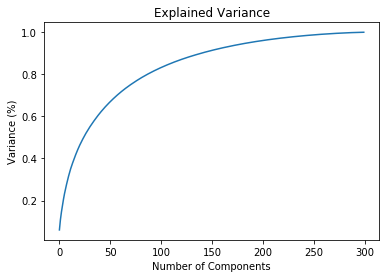

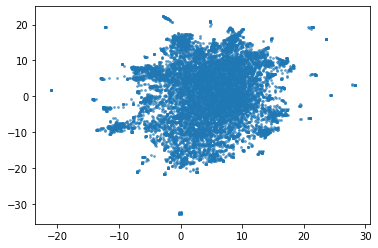

Number of outliers: 1654


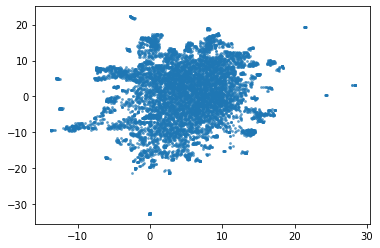



 The ideal number of clusters, based on average silhouette score is: 15


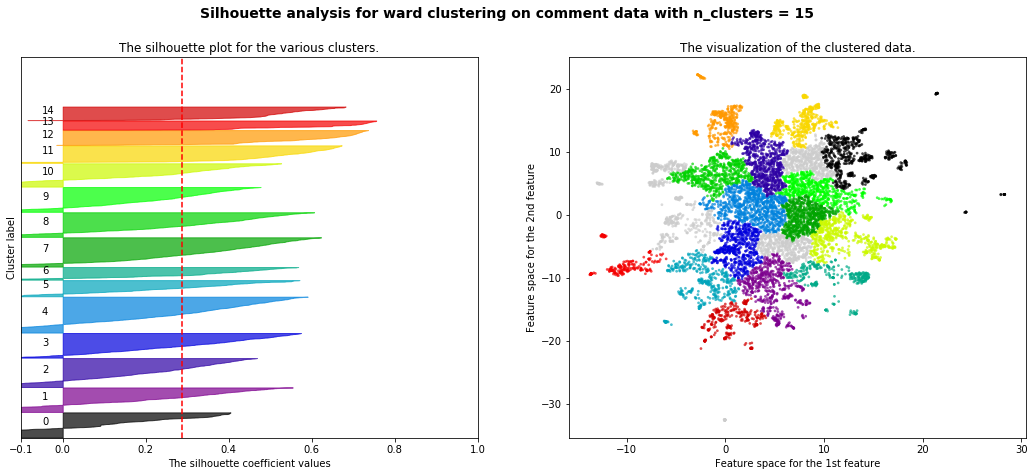

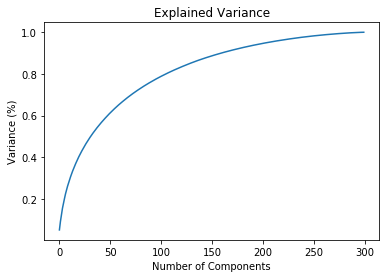

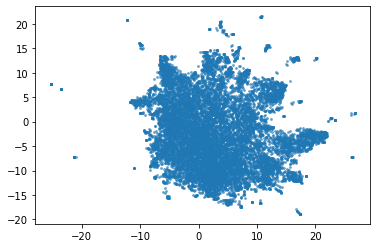

Number of outliers: 1976


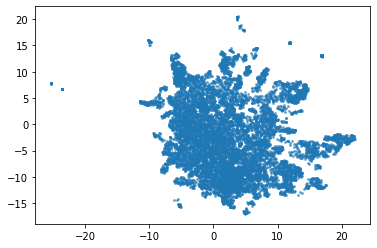



 The ideal number of clusters, based on average silhouette score is: 11


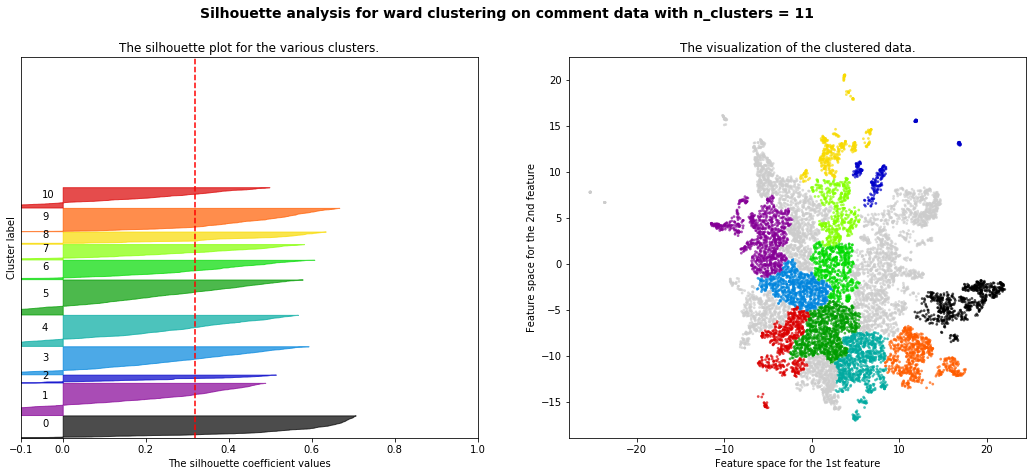

In [12]:
# Cluster validation for each question.

# Rewrite the csv.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding', 'x', 'y', 'Cluster ID']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()

    # For each question, load all information into arrays.
    for name, group in df_embeddings.groupby(['Question']):
        
        embeddings = []
        comments = []
        questions = []
        
        for index, row in group.iterrows():
            # Exclude embeddings with nan values.
            if len(row['Mean Embedding']) > 6:
                embeddings.append(np.asarray(eval(row['Mean Embedding'])))
                comments.append(row['Comment'])
                questions.append(row['Question'])
        
        X = np.array(embeddings)
        C = np.array(comments)
        Q = np.array(questions)

        # Normalize values between 0 and 1. 
        scaler = MinMaxScaler(feature_range=[0, 1])
        data_rescaled = scaler.fit_transform(X)

        #Plot the cumulative summation of the explained variance.
        pca = PCA().fit(data_rescaled)
        plt.figure()
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title('Explained Variance')
        plt.show()

        # Reduce dimensions for performance while maintaining majority of variance.
        pca = PCA(n_components=150)
        data = pca.fit_transform(data_rescaled)

        # Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.
        reducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)
        data_reduced = reducer.fit(data).embedding_
        plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
        plt.show()

        # Remove a certain percentage of outliers. Show the number of outliers.
        outlier_scores = LocalOutlierFactor(contamination=0.15).fit_predict(data_reduced)
        outlying_digits = data_reduced[outlier_scores == -1]
        print(f'Number of outliers: {outlying_digits.shape[0]}')
                                  
        # Transform all the lists according to the inlier data.        
        data_inliers = data_reduced[outlier_scores == 1]
        embeddings_inliers = X[outlier_scores == 1]
        comments_inliers = C[outlier_scores == 1]
        questions_inliers = Q[outlier_scores == 1]
        
        # Confirm that all the arrays are still the same length.
        if not len(data_inliers) == len(comments_inliers) == len(questions_inliers) == len(embeddings_inliers):
            print('Check your data. Something is faulty with the outliers.')
            break
                                  
        # Visualize the inlier data.
        plt.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
        plt.show()

        # Determine optimal number of clusters via silhouette method with ward agglomerative clustering.
        silhouette_scores = []

        # Arbitrary range of values for validation.
        for j in range(5, 21):

            # Compute clusters
            cluster_labels = AgglomerativeClustering(n_clusters=j, linkage='ward').fit(data_inliers).labels_         

            # Compute silhouette score for the current n_clusters.
            silhouette_avg = silhouette_score(data_inliers, cluster_labels)
            silhouette_scores.append((j, silhouette_avg))

        # Select n_cluster value with maximum silhouette as ideal number of clusters.
        max_silhouette = sorted(silhouette_scores, reverse=True, key=lambda x: x[1])[0][0]
        print(f'\n\n The ideal number of clusters, based on average silhouette score is: {max_silhouette}')

        # Initialize plots for silhouette scores and cluster visualization.
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # Inserting blank space between silhouette plots of individual clusters.
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(data_inliers)])

        sample_silhouette_values = silhouette_samples(data_inliers, cluster_labels)

        y_lower = 10
        for i in range(max_silhouette):

            # Aggregate scores for samples of same cluster and sort them.
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / max_silhouette)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute new y_lower for the next plot.
            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # Visualize the average silhouette score.
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Visualize the clusters.
        colors = cm.nipy_spectral(cluster_labels.astype(float) / max_silhouette)


        ax2.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for ward clustering on comment data"
                      " with n_clusters = %d" % max_silhouette),
                     fontsize=14, fontweight='bold')

        plt.show()
                                  
        # Compute cluster labels based on best silhouette score.
        cluster_labels = AgglomerativeClustering(n_clusters=max_silhouette, linkage='ward').fit(data_inliers).labels_   
                    
        # Write everything to the csv.
        for i in range(len(data_inliers)):
            writer.writerow({'Question': questions_inliers[i],
                             'Comment': comments_inliers[i],
                             'Mean Embedding': embeddings_inliers[i],
                             'x': data_inliers[i][0],
                             'y': data_inliers[i][1],
                             'Cluster ID': cluster_labels[i]})

In [13]:
# Load the new df.
df_clustered = pd.read_csv('data_tm.csv')
df_clustered.head(10)

,Question,Comment,Mean Embedding,x,y,Cluster ID
0,Please tell us what is working well.,"we do what our customers need, we communicate ...",[ 3.82995605e-02 -1.08886719e-01 -1.13037109e-...,12.293947,-3.756257,10
1,Please tell us what is working well.,customs business development continues to grow...,[-0.03769156 0.0623122 -0.00995577 0.037916...,7.609120,9.712749,3
2,Please tell us what is working well.,"i think the team work hard, are committed to c...",[-0.06420135 0.0406189 -0.0411911 0.073364...,0.395048,-3.048712,1
3,Please tell us what is working well.,overall working towards a customer centric env...,[-6.40106201e-02 4.86424752e-02 -6.19913749e-...,-0.796818,2.064275,9
4,Please tell us what is working well.,customer centricity is a growing culture in th...,[-0.04539871 0.07287598 -0.00360107 0.039733...,1.081660,17.120531,12
5,Please tell us what is working well.,develop a comfortable rapport with clients and...,[-1.96075439e-02 5.56640625e-02 -5.73263168e-...,-0.064577,1.195365,9
6,Please tell us what is working well.,"we are usually seeking customer satisfaction, ...",[-0.03935547 0.05855713 -0.0152977 -0.017370...,0.857618,13.951141,12
7,Please tell us what is working well.,alignment between regional office and country ...,[-8.23102668e-02 7.37304688e-02 4.56891721e-...,5.818973,9.560454,3
8,Please tell us what is working well.,i like the idea of customer 'ownership' at des...,[-0.05206299 -0.00166512 -0.10277176 0.090881...,1.243252,13.973885,12
9,Please tell us what is working well.,i think the company vision and goals are well ...,[ 0.00831299 0.025 0.00994263 0.090393...,11.300806,7.439560,6


In [14]:
# Assign cluster labels based on frequent key words.

# Rewrite the csv.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding', 'x', 'y', 'Cluster ID', 'Cluster Keywords']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    
    # Group by question.
    for name, question in df_clustered.groupby(['Question']):
        
        # Within question, group by cluster.
        for name, cluster in question.groupby(['Cluster ID']):
            
            # Extract everything to lists (this step is kinda messy).
            cluster_ids = []
            cluster_keywords = []
            comments = []
            questions = []
            x = []
            y = []
            embeddings = []
            
            nouns_in_segments = []

            for index, row in cluster.iterrows():
                embeddings.append(row['Mean Embedding'])
                comments.append(row['Comment'])
                questions.append(row['Question'])
                x.append(row['x'])
                y.append(row['y'])
                cluster_ids.append(row['Cluster ID'])
                
                # Extract all nouns from comment into a set.
                nouns = set()
                text = nltk.word_tokenize(row['Comment'].replace('[', '').replace(']', ''))
                text_tagged = nltk.pos_tag(text)
                for tpl in text_tagged:
                    if tpl[1] == 'NN' or tpl[1] == 'NNS':
                        nouns.add(tpl[0])

                nouns_in_segments.append(nouns)
                
            # Determine most frequency nouns by comparing all comments w each other.
            frequency_evaluation = []
            for segment_x in nouns_in_segments:
                for segment_y in nouns_in_segments:
                    intersection = segment_x.intersection(segment_y)
                    if len(intersection) > 0:
                        for item in list(intersection):
                            frequency_evaluation.append(item)

            # Isolate the ten most common nouns.
            counter = collections.Counter(frequency_evaluation)
            most_common = counter.most_common(10)
            keywords = []
            for item in most_common:
                keywords.append(item[0])

            # Use these top-ten nouns as keyword cluster labels.
            for index, row in cluster.iterrows():
                cluster_keywords.append(keywords)
                       
            # Write everything to the csv.
            for i in range(len(comments)):
                writer.writerow({'Question': questions[i],
                                'Comment': comments[i],
                                'Mean Embedding': embeddings[i],
                                 'x': x[i],
                                 'y': y[i],
                                'Cluster ID': cluster_ids[i],
                                'Cluster Keywords': cluster_keywords[i]})

In [15]:
# Load the final csv.
df_labeled = pd.read_csv('data_tm.csv')

Question: Please tell us what is working well.



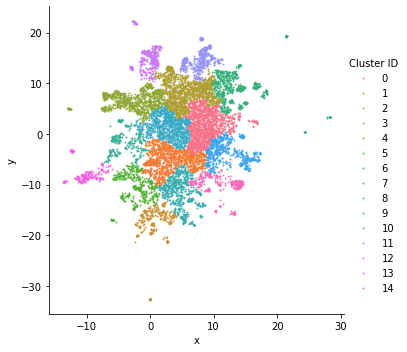

Cluster 0: ['Company', 'I', 'Employees', 'Time', 'Work', 'Team', 'People', 'Lot', 'Year', 'Management'] 

the service levels i believe are quite high taking into consideration the size of the company.
lots of big and positive changes taken place.
everything is great, the services that the company committed to give to our customers, the prizes employees are getting.



Cluster 1: ['Team', 'Work', 'Job', 'I', 'Company', 'People', 'Everyone', 'Time', 'Employees', 'Share'] 

i think the team work hard, are committed to continuous improvement and doing a good job for our customers.
working well is giving your best in all aspects.
working well is all about doing your job/work right at the first time.



Cluster 2: ['Team', 'Work', 'I', 'Members', 'Cooperation', 'Bonding', 'Feel', 'Employees', 'Group', 'Environment'] 

overall team is committed to customers and doing good work
in my point passionate,  responsibilty ,team work, undersating what i am doing
team work and excellence is working we

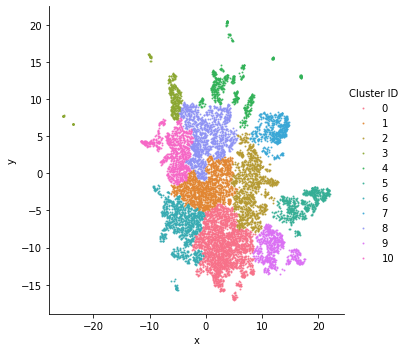

Cluster 0: ['I', 'People', 'Work', 'Time', 'Employees', 'Job', 'Company', 'Customers', 'Way', 'Team'] 

we have a less efficient bid process now that does not serve our customers as well, and it's resulting in more man-hours going into rfq proposals while jobs are cut elsewhere
i keep hearing that we have seen significant improvement, but we still have a long way to go.
our quote process on rfq, we need quote considering customer quote format rather just looking ipt.



Cluster 1: ['Company', 'Employees', 'I', 'Work', 'Team', 'Management', 'Business', 'Employee', 'People', 'Customers'] 

we are often acting based on opinion rather than facts.
the inter-company relationships between stations (p&ls) must be improved as well.
countries need to respect and honor rates they provide



Cluster 2: ['Employee', 'Staff', 'Work', 'Company', 'Job', 'Employees', 'Need', 'I', 'Time', 'Environment'] 

amount of work in 1 person.
planning & guide for handling the difficulties need support for error f

In [16]:
# Visualize the final results.
for name_question, question in df_labeled.groupby(['Question']):
    print(f'Question: {name_question}\n')
    
    # Visualize the UMAP reduced data with the cluster IDs.
    facet = sns.lmplot(data=question, x='x', y='y', hue='Cluster ID', 
                       fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
    plt.show()
    
    # Show some of the comments for each cluster.
    for name_cluster, cluster in question.groupby(['Cluster ID']):
        cluster_name = cluster.head(1)['Cluster Keywords'].get_values().tolist()[0]
        print(f'Cluster {name_cluster}: {cluster_name.title()} \n')
        print(*cluster.head(3)['Comment'].get_values().tolist(), sep='\n')
        print('\n\n')

In [ ]:
# TODO: Refactor into different functions because some cells are getting pretty lengthy.
# TODO: Improve embeddings with fasttext.
# TODO: Improve embeddings with BERT.
# TODO: More sophisticated cluster labeling method beyond mere frequency (try the cluster projection library).
# TODO: More sophisticated and interactive cluster visualization.
# TODO: Custom metric for evaluating different clustering pipelines (get creative).
# TODO: Optimize the parameters of all functions in the clustering pipeline.